In [34]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [35]:
!pip install pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import cv2
import torch
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import pytesseract
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.models import Sequential ,load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import glob

Sentence Transformers

In [55]:
from sentence_transformers import SentenceTransformer, util
sent_model = SentenceTransformer('all-MiniLM-L6-v2')

In [39]:
df = pd.read_csv('/content/java_syllabus.csv')

In [40]:
contents = [content for content in df['Contents'].values]

topics = [topic for topic in df['Topic'].values]

# display(topics)

Model of Number Recognition

In [41]:
model = load_model("/content/mnist.h5")

Image Processing

In [58]:
img_rgb = cv2.imread('/content/desc2.jpeg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
wid, hgt = img_gray.shape[::-1]
cv2_imshow(img_rgb)

Output hidden; open in https://colab.research.google.com to view.

In [59]:
ret, thresh1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU |
                                          cv2.THRESH_BINARY_INV)
# cv2.imwrite('threshold_image.jpg',thresh1)

# cv2_imshow(thresh1)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 6))
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)
# cv2.imwrite('dilation_image.jpg',dilation)
# cv2_imshow(dilation)

In [60]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_NONE)

im2 = img_rgb.copy()

In [61]:
list = []
c=0
max_marks =[]
cropped = ""
que = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Draw the bounding box on the text area
    cropped = im2[y:y + h, x:x + w]
    rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    cropped = img_gray[y:y + h, x:x + w]
    
    if(x< (wid*0.1)):
      # cv2_imshow(cropped)
      # cv2.imwrite("cropped"+str(c)+".jpeg",cropped)
      c+=1
      list.append([x,y,w,h])
    if(x> (wid*0.7)):
      # cv2_imshow(cropped)
      text = pytesseract.image_to_string(cropped)
      max_marks.append([text,x,y,w,h])
      # print(text)
    else :
      que.append([x,y,w,h])
     
   

In [62]:
final=[]
for i in max_marks:
  x="".join(ch for ch in i[0] if ch.isalnum())
  if x.isalnum():
    if x.__contains__("Marks"):
    # num = [int(ch) for ch in x.split() if ch.isdigit()] 
      final.append([int(x[0]), i[1] , i[2],i[3],i[4]])

In [63]:
# in this block we are coreleating max marks coordinates with question cooordinates and taking final output as 
# coordinates of a question and max marks for a question as list
f_que = []           
for m in final:
  comp = m[2]
  for q in que:
    if(abs(comp-q[1])) in range(0,15) and ((q[2]*q[3])>500):
      
      f_que.append([q,m[0]])

In [64]:
# for i in f_que:
#     print(i)
    

In [65]:
# for i in list:
#     print(i)

In [66]:
#In this block we coreleate coordinates of question and marks attained 
# we can have question coordinates , marks obtained coordinates , max marks in one list
ans = []
for l in list:
  comp = l[1]
  for m in f_que:
    if(l[1]-m[0][1] > 0 and l[1]-m[0][1]<comp):
      ans.append([l,m[0],m[1]])  # in ans list we have coordinates of marks obtained, question , max marks
      comp= l[1]-m[0][1]

In [67]:
c=0
for i in range(len(ans)):
  mark_img = im2[ans[i][0][1]:ans[i][0][1] + ans[i][0][3], ans[i][0][0]:ans[i][0][0] + ans[i][0][2]]
  mark_img = cv2.resize(mark_img, (28,28))
  # cv2_imshow(mark_img)
  cv2.imwrite("/content/obtained_marks/mark"+str(c)+".jpeg",mark_img)
  c+=1

Number Recognizer Function

In [68]:
def predict(path):
    image = cv2.imread(str(path))
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    grey =cv2.bitwise_not(grey)
    ret, thresh = cv2.threshold(grey.copy(), 100, 255, cv2.THRESH_BINARY)
    # cv2_imshow(thresh)
    resized_digit = cv2.resize(thresh, (18,18))
    digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)
    prediction = model.predict(digit.reshape(1, 28, 28, 1))  
    # plt.imshow(digit.reshape(28, 28), cmap="gray")
    # plt.show()
    return np.argmax(prediction)

1/1 [==============================] - 0s 23ms/step
Question:  vs Array?

Topic:  LINEAR DATA STRUCTURES
Max Marks 7 

Obtained Marks 4 



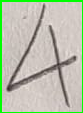

1/1 [==============================] - 0s 25ms/step
Question:  3. Python vs JAVA ?

Topic:  INTRODUCTION TO PROGRAMMING
Max Marks 5 

Obtained Marks 2 



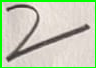

1/1 [==============================] - 0s 24ms/step


In [72]:
contents_embeddings = sent_model.encode(contents)    # Embedding contents data
for i in range(len(ans)):
  ques_img = im2[ans[i][1][1]:ans[i][1][1] + ans[i][1][3], ans[i][1][0]:ans[i][1][0] + ans[i][1][2]]  #taking question from its coordinates
  quest_txt = pytesseract.image_to_string(ques_img)     #converting image to text
  question_embedding = sent_model.encode(quest_txt)    ## Embedding question text
  scores = util.dot_score(question_embedding, contents_embeddings)
  max_index = torch.argmax(scores)
  # print(quest_txt)
  obt_marks_img = im2[ans[i][0][1]:ans[i][0][1] + ans[i][0][3], ans[i][0][0]:ans[i][0][0] + ans[i][0][2]]
  # cv2_imshow(obt_marks_img)
  cv2.imwrite("/content/mark.jpeg",obt_marks_img)
  mark=predict("/content/mark.jpeg")
  if((mark/ans[i][2])<0.6):
    print('Question: ', quest_txt)
    print('Topic: ', topics[max_index])
    print("Max Marks",ans[i][2],"\n")
    print("Obtained Marks",mark,"\n")
    cv2_imshow(obt_marks_img)